In [3]:
from collections import Counter
import numpy.random as r
import seaborn as sns
import numpy as np
from __future__ import division
%matplotlib inline
from scipy import stats
import matplotlib.pyplot as plt

** A Trite Example **

Let's talk Fantasy Football. Apologies if you hate sports, but some of the following metaphors and example problems will get us pretty far, so please bear with me.

On a Fantasy Football team, each of my players scores points (in accordance with rules for their position) for the game they play in real life each week. As an example let's look at quarterback Jameis Winston. After several weeks into the season, here's the points he got me:

In [27]:
Jameis_Winston = {"Week 1": 13, "Week 2": 18, "Week 3": 12, \ 
                  "Week 4": 12, "Week 5": 14, "Week 6": 0}

So we see that several weeks into the season, Winston seems like a pretty reliable source of about a dozen or so points. Sometimes he scores more (like when he got 18) and sometimes he scores less (like when he was on a BYE in Week 6 and got 0, but I didn't notice because I'm terrible at Fantasy Football). Our goal might be to *predict* how many points Winston will get in the next game. Or at least to have a compact quantification of how he's likely to do. He probably won't get 0 again, and he probably won't get 50, so how might we quantify all this? 

Since we've seen a few weeks of data, surely we can say something about this problem right? We're doing better than nothing. In the past we seen him acheive scores of 13, 18, 12, and 14, so a good starting point is to guess that those are somewhat likely in the future. What about 11 points? We've never seen that in the past, so does that have exactly zero chance of happening in the future? 

A good place to start is to devise a *generative model* of his scoring - to come up with a *probability distribution* that captures the variability in a reasonable way. We've talked about Binomial distributions and Normal distributions, but those aren't quite right here because of how they're defined and how the rules of my league go. In my leaguge, a player can only get an integer number of points. So it's certainly not a coin-flip process, but it's not really a drawn from a Normal distribution either. 

The distribution we're looking for is called the Poisson distribution. This distribution is defined only on the integers and is typically used to model count-data. For example, how many traffic tickets will I get this year? How many times will you sneeze tomorrow? How many points with Jameis Winston get this week? These are all count-data that can take on only whole-number values, and are appropriate for the Poisson distribution.

This is the Poisson distribution: 

$p(k|\lambda) = \frac{\lambda ^k}{k!} e^{- \lambda}$

To break that down a little bit - the distribution quantifies the probability of seeing $k$ counts, given a particular value of $\lambda$. The parameter $\lambda$ is called the *rate* parameter and quantifies the baseline probability of an event happening. In fact, recall the Binomial distribution discussed earlier. In that case, we asked what is the probability of observing $k$ Heads coin tosses if we do a total of $N$ tosses and have a probability of Heads is $\theta$. Well, the Poisson distribution is simply a limiting approximation of that process as $N$ goes to infinity (so we do an infinite number of coin tosses infinitely often). The Poisson rate parameter $\lambda$ is very closely tied to the Binomial probability parameter. 

Below, I'm visualizing the probability density of a Poisson distribution for two different values of $\lambda$. As you can see, as $\lambda$ increases, our expected counts tend to increase.

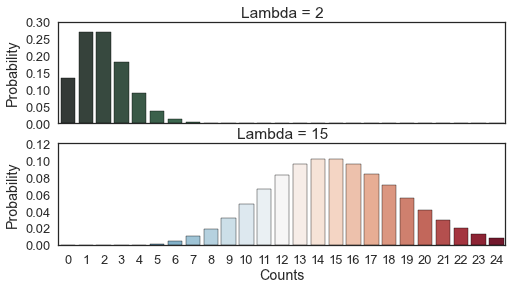

In [2]:

sns.set(style="white", context="talk")
rs = np.random.RandomState(7)


# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# Generate some sequential data
x = np.array(range(25))
poiss_1 = stats.poisson(2)
y1 = poiss_1.pmf(x)
sns.barplot(x, y1, palette="BuGn_d", ax=ax1)
ax1.set_ylabel("Probability")
ax1.set_title("Lambda = 2")

# Center the data to make it diverging
poiss_2 = stats.poisson(15)
y2 = poiss_2.pmf(x)
sns.barplot(x, y2, palette="RdBu_r", ax=ax2)
ax2.set_ylabel("Probability")
ax2.set_xlabel("Counts")
ax2.set_title("Lambda = 15")




So the Poisson distribution is a good thing to keep in mind for count data, but how can we use it? Well the general idea (and this is where we're headed) is that the number of points Jameis Winston gets every week is a random draw from some unknown Poisson distribution with some unknown $\lambda$. Once we know about $\lambda$, we have a decent model (the Poisson distribution) of how many points Winston typically gets. For example, Winston typically scores at least 12 points. Looking at the examples above, the Poisson distribution with $\lambda=2$ has *very little* probabilty of producing a count of 12. In constrast, the Poisson distribution with $\lambda = 15$ has a pretty good chance of producing a count of 12. So we qualitatively say that $\lambda$ is probably closer to 15 than it is to 2, for Jameis Winston. 

Our goal is estimate the best possible $\lambda$ (or even better, our full uncertainty/confidence about $\lambda$) so that we can quantify predictions about future games. This is called statistical inference. In fact, we'd also like to come up with a way to continually add new information from subsequent weeks to update our beliefs. This is called Bayesian inference. 

**Which Side Are You On?**

Let's restate some of our goals using some mathematical notation. Remember, we want to estimate this parameter $\lambda$ for Jameis Winston, so that we can quantify the full probability distribution over how many points he'll likely get. We've made some observations about his previous performance. We'll refer to these data points as $y$, so week 1 he scored $y_1$ points, week 2 he scored $y_2$ points, and full collection of data we will call $y_N$.

The question is, given that we observed $y_N$, what values of $\lambda$ are likely to have been the case to have generated those $y_N$. Because once we understand $\lambda$, we can make good predictions about the next game $y_{N+1}$.

Our goal then is to figure out this distribution: $p(\lambda | y_N)$ . This is the probability distribution over all possible values of $\lambda$, given what we know about the data. This may start to seem a little weird because we're treating $\lambda$ as a random variable, and this is the philosophical point of departure between Bayesian and Frequentist statistics. So let's dive into that distinction a little more.

To a Frequentist, the value of the parameter $\lambda$ for Jameis Winston is a fixed feature of the world. And the reason we have uncertainty about it, is because of the randomness of the Poisson distribution and the fact that we only have a few observations so far. This premise is what we undertook with our generative Monte Carlo methods. In the Frequentist world, our uncertainty comes our finite sample size, and so we ask questions about the *sampling distribution*. Recall that the idea was to ask What is the set of possible things I would see if I repeated this experiment over and over. The Frequentist approach to this problem would ask, What is the set of possible $y_N$ I might have seen if $\lambda$ was equal to some fixed number? And then, the trick is the find the $\lambda$ that would produce the best match the data we *actually* saw. 

To a Bayesian, we might still think of $\lambda$ as a fixed feature of the world, but we're going to confront our uncertainty about it and model that with probability, thus *pretending* that $\lambda$ too is a random variabile just like $y_N$. In the Bayesian world, we don't care about the question What might I see if I repeat this experiment over and over. We don't get to repeat the experiment, we simply have some fixed data and now we ask what possible values of $\lambda$ could have produced that data. In the Bayesian view, we address uncertainty about the world by treating it as probability of over possible truths. 


Given this differing point of departure, Bayesian inference has some new features that we'll need to get familiar with.


** Before And After: Bayes Rule **
    
Now let's return to our fantasy football problem, and let's make our questions as simple as possible. Imagine that it is the beginning of Week 2 and we want to quantify our uncertainty about Winston's upcoming performance. We only have one observation to speak of, and that's that he got us 13 points in Week 1. We know that something around 13 is a good guess for week 2, but by now we've learned a few things to keep in mind. We know that a Poisson distribution would be a good model. And we know that we want to have a good understanding of the $\lambda$ for that Poisson distribution. 

We want to quantify this: $p(\lambda | y_1)$. In the world of Bayesian inference, this probability distribution is called the *posterior distribution*. It captures our uncertainty about $\lambda$ given what we saw in week 1, $y_1$. And there's a simple expression called Bayes' rule that tells us how to find it:

$p(\lambda | y_1) = \frac{p(y_1 | \lambda) p(\lambda)}{p(y_1)} $

Bayes' rule has four parts. 

*The posterior* : $p(\lambda | y_1)$

*The likelihood* : $p(y_1 | \lambda)$

*The prior* : $p(\lambda)$

*The marginal* : $p(y_1)$

The marginal we can ignore because it is unrelated to $\lambda$, so pretend you never saw it. Most commonly, you'll see Bayes rule written like this $p(\lambda | y) \propto p(y| \lambda)p(\lambda)$. The posterior is the thing we want. The likehood is something we've seen before and thought about before, though maybe didn't call it out directly. It is the generative process underlying the data. It is the probability of observing $y$ given a particular vlaue of $\lambda$. Recall the example above where the different Poisson distribution with different values of $\lambda$ were more and less likely to have produced a count of 12. That's the likelihood, and in this case we know the likelihood is just the Poisson probability, so $p(y|\lambda) = \frac{\lambda ^y}{y!} e^{- \lambda}$.

The final piece of Bayes rule, and the most unfamiliar, is the prior, $p(\lambda)$. This is a probability distribution over the values that $\lambda$ likely is, *before* we gathered any observations. Since it comes *before* the data, or independently of the data, it is called the *prior*. We can use this distribution to quantify our prior beliefs about $\lambda$ before the season starts. For example, before the season starts, we can guess that $\lambda$ probably isn't very close to say 50, because that would corresond to a player that get like 50 points per week, and no one does that. And we might have some hunch that $\lambda$ could be 0, because players get injured all the time and have to sit out for a season. So the prior, $p(\lambda)$, is any distribution we want to use to quantify our prior beliefs, intution, and hunches. 

And this is a big sticking point in the Bayes-vs-Frequentist question. The very fact that I used the word "hunch" probably seems unscientific; hunches shouldn't affect our analyses and conclusions. This is a good point, but one I don't want to belabor. In the next section, we'll discuss choosing priors carefully. But if we don't want to inject too much prior bias into our analysis, then we can set the prior to be very "uninformative". But in Bayesian inference, we at least have this choice of including side information when we trust it. 

So back to our problem. Bayes rule tell us $p(\lambda | y_1) \propto p(y_1 | \lambda) p(\lambda)$. In the next section, we'll talk about choosing $p(\lambda)$ and getting a nice expression for the posterior, but at this point let's just think about what Bayes' rule is telling us. Our guess about something out in the world ( the $\lambda$) should be a combination of something we observed (the likelihood $p(y_1|\lambda)$) and the stuff we thought we knew before (the prior $p(\lambda)$). But notice that we can use this general premise and pattern repeatedly. On Week 2, we can use the data from Week 1 to update our prior and result in a posterior for $\lambda$. But then on Week 3, we can use our previous posterior as our new prior, and combine that with data from Week 2, to arrive at an updated prior. So in this way, Bayes' rule is all about updating our previous beliefs with all the information available to us at the time. 




** Conjugate Priors **

At this point, we've met the typical cast of characters in Bayesian models: the posterior, the likelihood, and the prior. From Bayes' rule, we know we that we can simply multiply the likelihood and the prior to get at the posterior. To be a little more explicit, suppose I want to know the posterior probability that $\lambda=2$, given the number of points from Week 1. Well, we know that 

$p(\lambda=2 | y_1) \propto p(y_1 | \lambda =2) p(\lambda=2)$.

So we can come up with some prior probability for $p(\lambda=2)$ and we could be on our way, no matter what the prior is. But recall that the goal of Bayesian analysis is to have a full underrstanding the posterior, $p(\lambda|y_1)$. That is, we're typically not interested in just the value $\lambda=2$, but want a quantification of all possible values of $\lambda$. So instead of a posterior probability at a single value of $\lambda$, we would like to have a nice, simple expression for the entire probability distribution over $\lambda$. Well, if we choose the form of the prior carefully, then it will combine with the likelihood in a useful way, such that the full posterior distribution has a simple form. This endeavor is called choosing a *conjugate prior*.

We know that we have a Poisson likelihood: $p(y | \lambda) = \frac{\lambda ^y}{y!} e^{- \lambda}$. So how can we figure out what the conjugate prior is for a Poisson likelihood? Well, long story short, consult this super useful wikipedia table (https://en.wikipedia.org/wiki/Conjugate_prior), and we find that the conjugate prior is the Gamma distribution. 

The Gamma distribution is a probability distribution over the positive real numbers and has two parameters, the rate $\alpha$ and the shape $\beta$ that control the location and width of the distribution. The form of the Gamma distribution is,

$
p(\lambda|\alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha -1} e^{-\beta \lambda}
$

Let's take a look at a few different Gamma distributions.


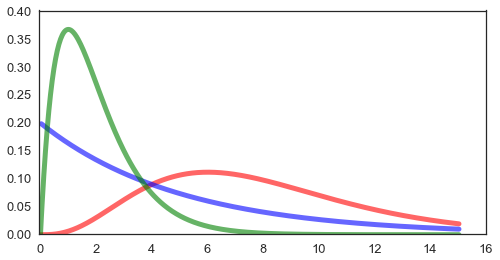

In [4]:
from scipy.stats import gamma
sns.set(style="white", context="talk")
rs = np.random.RandomState(7)


# Set up the matplotlib figure
f, ax  = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

x = np.linspace(0,15, 500)
ax.plot(x, gamma.pdf(x, 4,loc=0, scale=2),'r-', lw=5, alpha=0.6, label='gamma pdf')
ax.plot(x, gamma.pdf(x, 1,loc=0, scale=5),'b-', lw=5, alpha=0.6, label='gamma pdf')
ax.plot(x, gamma.pdf(x, 2, loc=0, scale=1),'g-', lw=5, alpha=0.6, label='gamma pdf')

A couple characteristics of the Gamma distribution. It's mean should be centered around $\frac{\alpha}{\beta}$. Also note that as $\alpha$ and $\beta$ get larger, the distribution gets more narrow. And note that in the special case where $\alpha = 1$, the Gamma distribution is simply the exponential distribution. 


So I said that the Gamma distribution is the conjugate prior for a Poisson likelihood. Let's walk through why this is and what it means.

Back to applying Bayes' rule, [Come back and fix this derivation]

$p(\lambda | y) \propto p(y|\lambda)p(\lambda)$

We fill in the likelihood and the prior,
$p(\lambda | y) \propto \frac{\lambda ^y}{y!} e^{- \lambda} \frac{\theta^{\alpha - 1} e^{- \theta / \beta}}{\beta^\theta \Gamma(\theta)} $.

Things are getting a little messy looking, but we have some terms that are normalization constants, so we can ignore those by sweeping them into the proportionality,

$p(\lambda | y) \propto \frac{\lambda ^y}{y!} e^{- \lambda} \frac{\lambda^{\alpha - 1} e^{-\lambda / \beta}}{\beta^\lambda \Gamma(\lambda)} \\
\propto \lambda ^y e^{- \lambda} \frac{\lambda^{\alpha - 1} e^{\lambda / \beta}}{\beta^\lambda}\\
\propto \frac{\lambda ^y}{ {\beta^\lambda}} e^{- \lambda} \lambda^{\alpha - 1} e^{-\lambda / \beta}\\
= \frac{1}{{\beta^\lambda}} \lambda^y \lambda^{\alpha -1} e^{-\lambda}e^{-\lambda / \beta}
$


We can see that there's some similar terms we can combine,

$p(\lambda | y) \propto  \lambda ^ {y + \alpha - 1} e^{- \lambda (1+ 1/\beta)}  $

You might notice that this is the form of the Gamma distribution. So we know that if we have a Poisson likelihood, and a Gamma prior, then the posterior for $\lambda$ is 

$p(\lambda|y) = \textrm{Gamma}(A,B)\\
\textrm{where } A= y + \alpha, B = \frac{\beta}{1+\beta}.
$

This, then, is the basic point about using conjugate priors. We have a simple expression for our posterior of interest, and the parameters of the posteriors can simply calculated from the data and the prior (for example, $A = y + \alpha$).

So now we can put this knowledge to use with our fantasy football data. Again, let's say it's after Week 1 and we have just one observation, $y_1 = 13$. We want to estimate $\lambda$ for Jameis Winston so that we can make better predictions for Week 2. We're going to use a Gamma prior, and calculate the posterior for $\lambda$ given the Week 1 score. What should the prior be? Well, using the Gamma prior, if we set $\alpha=1$, we get an exponentially decaying distribution. This distribution would be very broad, and simply imply that we think Winston is more likely to get a lower number of points than a large number of points, and this distribution has some non-negligible probability at exactly zero. I would say that this is a pretty good (and vague/non-informative) prior for before the season even starts. So we'll use this to represent our prior knowledge before the Week 1 outcome, $p(\lambda) = \textrm{Gamma}(1,2)$.

Since this is a conjugate prior, we know immediately that the posterior is,

$p(\lambda | y_1) = \textrm{Gamma}(y_1 + 1)(\frac{2}{1+2}) \\
= \textrm{Gamma}(14)(\frac{2}{3})
$. 

So let's take a look at how our prior was updated into our posterior. 

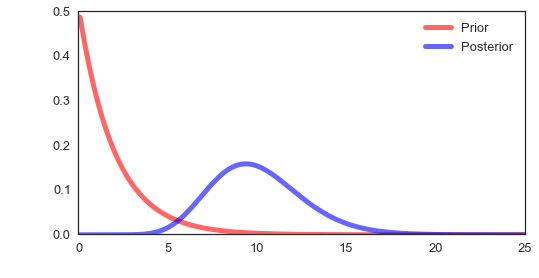

In [4]:
from scipy.stats import gengamma, gamma
sns.set(style="white", context="talk")
rs = np.random.RandomState(7)


# Set up the matplotlib figure
f, ax  = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

x = np.linspace(0,25, 500)
ax.plot(x, gamma.pdf(x, 1, loc=0,scale=2),'r-', lw=5, alpha=0.6, label='Prior')
ax.plot(x, gamma.pdf(x, 15, loc=0, scale=2/3),'b-', lw=5, alpha=0.6, label='Posterior')
plt.legend()


So, now we can do this process repeatedly, and see how our data updates our prior into our likelihood. For Week 2, we'll use as the prior the posterior from Week 1. So


$
p(\lambda | y_2) = p(y_2|\lambda) p(\lambda) \\
= p(y_2|\lambda) \textrm{Gamma}(14)(2/3)
= \textrm{Gamma}(14 + 18)( (4/10))
$

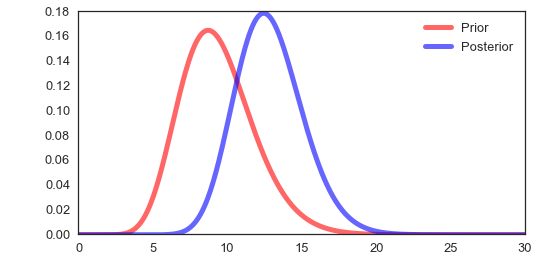

In [25]:
# Set up the matplotlib figure
f, ax  = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

x = np.linspace(0,30, 500)
ax.plot(x, gamma.pdf(x, 14, loc=0, scale=2/3),'r-', lw=5, alpha=0.6, label='Prior')
ax.plot(x, gamma.pdf(x, 32, loc=0, scale=(4/10)),'b-', lw=5, alpha=0.6, label='Posterior')
plt.legend()

Now we're starting to have a really good idea of what $\lambda$ is for Jameis Winston. Let's skip ahead several weeks and use all the data available to us. Instead of considering one new data point at a time and updating the posterior, it is equivalent to consider them all at once, if we have it. This is the more common way of doing things, and better matches the form of the conjugate prior table on the wikipedia page. That is,

$p(\lambda | y_N) = \textrm{Gamma}(A)(B)\\
\textrm{where  } A = \alpha + \sum_{i} y_i, B = \frac{\beta}{N \beta + 1}
$


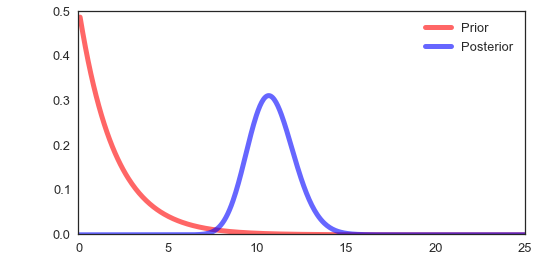

In [31]:
f, ax  = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

A = sum(Jameis_Winston.values()) + 1
B =2/ (len(Jameis_Winston.values()) * 2 + 1)

x = np.linspace(0,25, 500)
ax.plot(x, gamma.pdf(x, 1, loc=0, scale=2),'r-', lw=5, alpha=0.6, label='Prior')
ax.plot(x, gamma.pdf(x, A, loc=0, scale= B ),'b-', lw=5, alpha=0.6, label='Posterior')
plt.legend()

** Posterior Predictive Distribution **

Now, let's combine our posterior inference for $\lambda$ with the Monte Carlo methods we learned earlier. What we're going to do is simulate the *posterior predictive distribution* to get a sense of how many points Winston might get in the next game. In actuality, we don't have to simulate this with Monte Carlo methods, there's a closed form for this distribtion in the conjugate priors table, but this is more fun.

So we know that our full uncertainty about the $\lambda$ for Jameis Winston is captured by our posterior distribution - the Gamma distribution with parameters that are calculated from the data. And we know that given any value of $\lambda$, we could calculate probability of scoring any number of points (the Poisson likelihood). So we can combine these two stochastic processes in order to quantify predictions about future outcomes. We could calculate this future distribution with some kind of convolution integral, but we're not going to do that, we'll use Monte Carlo integration. 

From our posterior, any value of $\lambda$ drawn from that distribution would be a good guess of what the true value of $\lambda$ is. Our Monte Carlo strategy will be to take random draws from the posterior, and the use that value as the $\lambda$ for a Poisson likelihood and the simulate the outcome of a game. As we repeat this Monte Carlo procedure many times, we will arrive at a distribution over possible score outcomes which fully samples our uncertainty about $\lambda$.

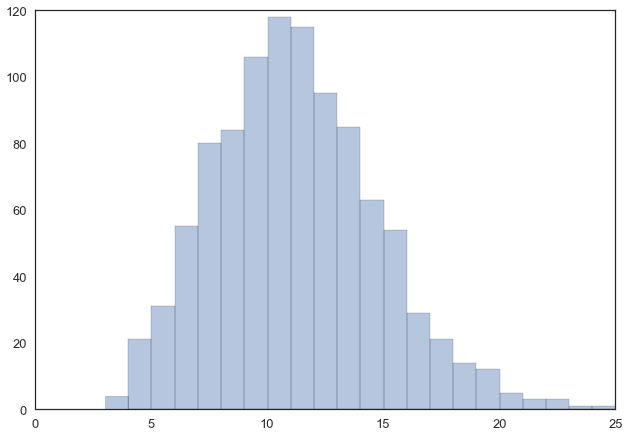

In [33]:
A = sum(Jameis_Winston.values()) + 1
B =2/ (len(Jameis_Winston.values()) * 2 + 1)
posterior_samples = gamma.rvs(A, loc=0, scale= B, size=1000)

score_samples = [np.random.poisson(lam=lambda_val, size=1) \
                 for lambda_val in posterior_samples]
sns.distplot(score_samples, kde=False, rug=False)

** Revisit A Simple Example **

In [5]:
import numpy.random as r
from collections import Counter

For the sake of completeness, let's revisit our coin-tossing example to see what the Bayesian solution to this question is. Remember, we see some tosses of a (potentially) unfair coin and we want to quantify our level of suspicion. The tosses we see are:

In [31]:
tosses = r.choice(["H","T"],50, p=[.3,.7])
Counter(tosses)

Counter({'T': 37, 'H': 13})

Given that we saw a certain number of Heads, should be suspicous? Previously, we went down the Frequentist path and asked how common our observed data is amongst all the possible outcomes. But now that we have some familiarity with Bayesian methods, we can think about question in a different way. Really, we want to know what is the value of $\theta$, the probability of tossing Heads, and how confident can we be that it is differet than $1/2$. In the langauge of Bayes, we're talking about the posterior distribution, $p(\theta|y_N)$. That is, of all the different possible values of $\theta$, which ones are most probable given the data?

Recall previously when we discussed the Binomial distribution. That is, the probability of seeing $k$ Heads given $N$ tosses and a probability of Heads per toss of $\theta$,

$
p(k|N) = \frac{N!}{k! (N-k)!}\theta^{k} (1-\theta)^{N-k}
$

Well now, this forms our Likelihood, an important part of Bayes rule. So we can start to put together the posterior,

$p(\theta|y_N) \propto p(y_N|\theta)p(\theta)\\
\propto \frac{N!}{k! (N-k)!}\theta^{k} (1-\theta)^{N-k} p(\theta).
$

At this point, we know we have to figure out the prior, $p(\theta)$. You might guess that there's a particularly convenient prior which is conjugate to the Binomial likelihood. You'd be right, it's called the Beta distribution. This distribution is defined on the unit interval and has two parameters that control its shape and location. 

$p(\theta)=\textrm{Beta}(\theta;a,b)\\
= \frac{1}{\beta(a,b)}\theta^{a-1}(1-\theta)^{b-1}
$

Here's a few examples. 

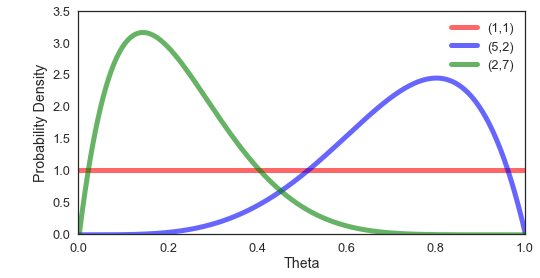

In [7]:
# Set up the matplotlib figure
from scipy.stats import beta
f, ax  = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

x = np.linspace(0,1, 500)
ax.plot(x, beta.pdf(x, 1,1),'r-', lw=5, alpha=0.6, label='(1,1)')
ax.plot(x, beta.pdf(x, 5,2),'b-', lw=5, alpha=0.6, label='(5,2)')
ax.plot(x, beta.pdf(x, 2,7),'g-', lw=5, alpha=0.6, label='(2,7)')
ax.set_xlabel("Theta")
ax.set_ylabel("Probability Density")
plt.legend()

I'll gloss over the full derivation, but when we use this conjugate Beta prior, we get a Beta posterior distribution.

$
p(\theta|y_N) \propto \frac{N!}{k! (N-k)!}\theta^{k} (1-\theta)^{N-k} \frac{1}{\beta(a,b)}\theta^{a-1}(1-\theta)^{b-1} \\
\propto \theta^{k+a -1} (1-\theta)^{N-k+b-1} \\
= \textrm{Beta}(A,B) \\
\textrm{where } A= (k+a), B = (N-k+b) 
$

So the posterior over $\theta$ is a Beta distribution with parameters that are easily calculated from the data and from the prior. 

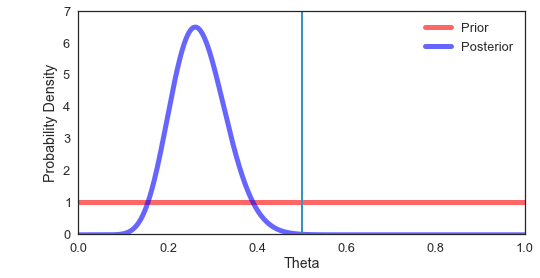

In [36]:
f, ax  = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

num_H = Counter(tosses)["H"]
N = len(tosses)

x = np.linspace(0,1, 500)
ax.plot(x, beta.pdf(x, 1,1),'r-', lw=5, alpha=0.6, label='Prior')
ax.plot(x, beta.pdf(x, num_H+1,N-num_H+1),'b-', lw=5, alpha=0.6, label='Posterior')
ax.set_xlabel("Theta")
ax.set_ylabel("Probability Density")
ax.axvline(x=.5,linewidth=2, color='#3690C0')
plt.legend()

From the data and the prior, we know have a posterior distribution that quantifies our full uncertainty about the true value of $\theta$. With this distribution, we can ask what is the posterior probability of $\theta$ being $1/2$ or higher.

In [38]:
1 - beta.cdf(.5, num_H+1,N-num_H+1)

0.00031052172811385503

This very low posterior probability, much like Frequentist hypothesis tests, convinces us that this observed data does not support the hypothesis that $\theta=1/2$.

** Next Step**

In this section, we learned about posterior inference through the use of conjugate priors. Picking our priors cleverly gives us a simple and useful form for the posterior. For many kinds of data and relationships, but right conjugate priors have already been figured out by smart people (see that Wikipedia table). However, we will hit a limitation to the complexity of models we can consider and compute by hand. In the next section, we'll tackle some computational methods (called Markov chain Monte Carlo) that let us address posterior inference in models of arbitrary complexity. 